# Stress Classifier
## Overview
* Data Extraction: Downloads and sorts through database
* Signal processing: 
    + Pre-processing - filtering and signal cleaning
    + Feature Extraction - R-R peaks, PQRST peaks, EDR, in addition to mean, kurtosis etc.

## Settings and Globals
Modify settings to select database, model etc. and tune model

In [1]:

# SETTINGS

# Database:
database = "Spider" # database = "BrainPatch"

# Preprocessing / Feature Extraction:
window_length = 40 # window length in seconds
overlap = 0.1 # overlap percentage for rolling window (increasing will result in more overlapped samples)

if database == 'Spider':
    sampling_rate = 100
    number_of_participants = 56

directory = f'Data/{database}/StoredDataFrames/'

In [2]:
# Import necessary modules
import pandas as pd
import numpy as np
import neurokit2 as nk
# for interactive matplotlib
# %matplotlib widget 
import matplotlib.pyplot as plt
import os
import subprocess
import warnings

In [3]:
# Useful Utilities
class Utilities():
    def __init__(self) -> None:
        pass
    

    def progress_bar(current, total, bar_length=20):
        fraction = current / total

        arrow = int(fraction * bar_length - 1) * '-' + '>'
        padding = int(bar_length - len(arrow)) * ' '

        ending = '\n' if current == total else '\r'

        print(f'Progress: [{arrow}{padding}] {int(fraction*100)}%', end=ending)


    def print_overwrite(msg):
        # add padding to line 
        padding = ' ' * 20
        # Print the padded message and remember it as the previous message
        print(msg+padding, end="\r")


    def save_dataframe(df, folder_path, index):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        filename = os.path.join(folder_path, f'df_{index}.csv')
        df.to_csv(filename, index=False)

    
    def save_list_of_dataframes(df_list, folder_path):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        # save each dataframe as a CSV file in the folder
        for i, df in enumerate(df_list):
            filename = os.path.join(folder_path, f'df_{i}.csv')
            df.to_csv(filename, index=False)
            Utilities.progress_bar(i+1, len(df_list))


    def check_csv_exists(folder_path, index):
        # read the CSV file into a dataframe and append to the list
        filename = os.path.join(folder_path, f'df_{index}.csv')
        try:
            df = pd.read_csv(filename)
        except FileNotFoundError:
            return False
        return filename


    def load_dataframe(filename):
        # read the CSV file into a dataframe and append to the list
        df = pd.read_csv(filename)
        return df


    def merge_dataset_columns(df1, df2):
        # concatenate the two dataframes with the new dataframe in between
        return pd.concat([df1, df2], axis=1)
    
# Bigger plots
plt.rcParams['figure.figsize'] = [15, 5]  
plt.rcParams['font.size']= 14

In [4]:
# Define DataExtraction class
class DataExtraction():
    def __init__(self, save_to_path):
        self.save_to_path = save_to_path


    # Extract data and store to file named Data
    def download_data(self):
        if database == 'Spider':
            directory = 'Data/Spider'
            url = 'https://physionet.org/files/ecg-spider-clip/1.0.0/'
            if not os.path.isdir(directory):
                print("Downloading database...this may take a while")
                os.makedirs(directory)
                cmd = f"wget -r -N -c -np -P {directory} {url}"
                print(cmd)
                try:
                    subprocess.run(cmd)
                except:
                    print("Error: Unable to download database")
                    os.rmdir(directory)
            else:
                print("Using pre-downloaded database")
    

    # sorts data into a single dataframe for each participant into a collective dataframe list
    def sort_data(self):
        print("Sorting data...")

        # try loading existing df if available
        if os.path.isdir(self.save_to_path):
            return
        
        # otherwise create dataframe from scratch
        ECG_df = []

        if database == 'Spider':
            database_directory = 'Data/Spider/physionet.org/files/ecg-spider-clip/1.0.0/'
            # Exclude VP70 because of noise
            sub_directories = ['VP02', 'VP03','VP05','VP06','VP08','VP09','VP11','VP12','VP14','VP15','VP17','VP18','VP20','VP23','VP24','VP26','VP27',
                    'VP29','VP30','VP32','VP33','VP35','VP36','VP38','VP39','VP41','VP42','VP44','VP45','VP47','VP48','VP50','VP51','VP53',
                    'VP54','VP56','VP57','VP59','VP61','VP62','VP63','VP64','VP65','VP66','VP68','VP69','VP71','VP72','VP73','VP74',
                    'VP75','VP76','VP77','VP78','VP79','VP80']
            for index, sub in enumerate(sub_directories):
                # set path
                ECG_file = f'{database_directory}{sub}/BitalinoECG.txt'
                triggers_file = f'{database_directory}{sub}/Triggers.txt'

                # append data to dataframe
                ECG_participant_df = pd.read_csv(ECG_file, sep='\t', names = ['ECG','Timestamp','NA'])
                ECG_participant_df = ECG_participant_df.drop(columns=['NA'])
                
                # set the start time to use to normalize the other times
                normalized_time = ECG_participant_df.iloc[0,1]
                ECG_participant_df.Timestamp = ECG_participant_df.Timestamp-normalized_time

                # read in trigger file
                triggers_df_temp = pd.read_csv(triggers_file, sep='\t', names = ['clip','on','off'])
                # normalize time series
                triggers_df_temp.on = triggers_df_temp.on-normalized_time
                triggers_df_temp.off = triggers_df_temp.off-normalized_time

                # Create the 'Stressed' (label) column with all zeros
                ECG_participant_df["Stressed"] = np.zeros(len(ECG_participant_df))
                # This checks which time stamps fall into the time ranges when the clips are delivered (ignoring demo clip), results in a column of "true" and "false"
                conditions = pd.concat([(ECG_participant_df['Timestamp'] >= triggers_df_temp.on[i]) & (ECG_participant_df['Timestamp'] <= triggers_df_temp.off[i]) for i in range(1,17)],axis=1).any(axis=1)
                ECG_participant_df["Stressed"] = conditions
                # move stressed label to first column
                ECG_participant_df.insert(0, "Stressed", ECG_participant_df.pop('Stressed'))

                # append data to complete df dictionary
                ECG_df.append(ECG_participant_df)

                Utilities.progress_bar(index, len(sub_directories)-1)

        # save dataframe for nextime
        print("Saving sorted data...")
        Utilities.save_list_of_dataframes(ECG_df, self.save_to_path)

In [5]:
# Define PreProcessing Class:
# Segments data using rolling window 
# Cleans data using Neurokit2
# Documentation can be found here: https://neuropsychology.github.io/NeuroKit/functions/ecg.html       
class PreProcessing():
    def __init__(self, ECG_df, sampling_rate):
        self.ECG_df = ECG_df
        self.sampling_rate = sampling_rate

    # interpolates data to achieve sampling rate
    def interpolate(self):
        if database == 'Spider':
            print("Timestamps are not valid for Spider database. Not interpolating.")
            return

        # convert timestamp column to a NumPy array
        timestamps = self.ECG_df['Timestamp'].to_numpy()

        # calculate the time difference between each pair of adjacent timestamps
        time_diff = np.diff(timestamps)

        # calculate the average sampling rate of the data
        sampling_rate = 1 / np.mean(time_diff)

        print(f"Average sampling rate: {sampling_rate}")

        # interpolate the data to obtain 100Hz sampling rate
        self.ECG_df['Timestamp'] = np.arange(timestamps[0], timestamps[-1], 1 / self.sampling_rate)
        self.ECG_df['ECG'] = np.interp(self.ECG_df['Timestamp'], timestamps, self.ECG_df['ECG'])
        

    # segments data with overlap using rolling window
    def segment(self, window_length, overlap)->tuple:
        Utilities.print_overwrite("Segmenting data...")
        # convert window_length in seconds to samples
        window_samples = window_length * sampling_rate
        # Calculate the step_size as the fraction of the total window samples
        step_size = int(window_samples * (1-overlap)) 

        # Save windowed samples to numpy array
        self.stressed_ECG = []
        self.not_stressed_ECG = []

        # Initialize starting variables
        current_index = 0
        current_stressed = self.ECG_df['Stressed'][current_index]
        
        # Loop through the entire dataframe
        while current_index < len(self.ECG_df['ECG']):  
            # calculate next index and exit if out of bounds          
            next_index = current_index + step_size
            if (next_index > len(self.ECG_df['ECG'])):
                return
            # Check if the window overlaps different label in next window
            next_stressed = self.ECG_df['Stressed'][next_index]

            # If the next window has a different label, update index to start of new label
            if next_stressed != current_stressed:
                current_index = next_index
                current_stressed = next_stressed
            else:
                # Extract the window into stressed or not stressed dataframes
                if current_stressed:
                    self.stressed_ECG.append(self.ECG_df['ECG'].iloc[current_index:current_index+window_samples].to_numpy())
                else:
                    self.not_stressed_ECG.append(self.ECG_df['ECG'].iloc[current_index:current_index+window_samples].to_numpy())
                # If the next window has the same label, shift the window
                current_index += step_size


    def clean(self):
        Utilities.print_overwrite("Cleaning data...")

        # Clean each sample in the stressed and not stressed data by overwriting
        # using method 'neurokit' (0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering) but can be changed to other cleaning methods
        for sample in self.stressed_ECG:
            sample = nk.ecg_clean(sample, self.sampling_rate, method='neurokit')
        for sample in self.not_stressed_ECG:
            sample = nk.ecg_clean(sample, self.sampling_rate, method='neurokit')

    # returns list of samples - stressed and not stressed
    def get_samples(self):
        return {"Stressed": self.stressed_ECG, "Not stressed": self.not_stressed_ECG}

In [6]:
# Define FeatureExtraction Class               
class FeatureExtraction():
    # takes in cleaned ECG data
    def __init__(self, sampled_ECG:dict, show_plot=False):
        self.show_plot = show_plot
        self.sampled_ECG = sampled_ECG
        # copy dictionary keys and size from sampled_ECG to featured_ECG
        self.featured_ECG = {}
        for label in self.sampled_ECG.keys():
            self.featured_ECG[label] = [None] * len(self.sampled_ECG[label])


    def add_to_featured_df(self, df, label, index):
        # check if dataframe uninitialised
        if self.featured_ECG[label][index] == None:
            self.featured_ECG[label][index] = df
        else:
            # concatenate with featured data and save to file
            self.featured_ECG[label][index] = pd.concat(self.featured_ECG[label][index], df, axis=1)


    # Extracts features from ECG using neurokit.
    def neurokit_features(self, HRV=True, EDR=True):
        for label in self.sampled_ECG.keys():
            for index, sample in enumerate(self.sampled_ECG[label]):
                # only show plot once
                if index!=0:
                    self.show_plot = False 
                # extract R-R peaks
                np.seterr(divide="ignore", invalid="ignore")
                r_peaks_df = nk.ecg_peaks(sample, sampling_rate=sampling_rate, correct_artifacts=True)[0]

                # Extract HRV features from R-R peaks, see https://neuropsychology.github.io/NeuroKit/functions/hrv.html 
                if HRV:
                    Utilities.print_overwrite("HRV Extraction...")    
                    # compute HRV - time, frequency and nonlinear indices.
                    warnings.filterwarnings('ignore') # temporarily supress warnings
                    HRV_df = nk.hrv(r_peaks_df, sampling_rate=sampling_rate, show=self.show_plot)
                    warnings.filterwarnings('default')
                    # add feature to dataframe
                    self.add_to_featured_df(HRV_df, label, index)

                if EDR:
                    Utilities.print_overwrite("EDR Extraction...")    
                    # Get ECG Derived Respiration (EDR) and add to the data
                    ecg_rate = nk.signal_rate(r_peaks_df, sampling_rate=sampling_rate, desired_length=len(r_peaks_df))
                    EDR = nk.ecg_rsp(ecg_rate, sampling_rate=sampling_rate)
                    # add feature to dataframe
                    self.add_to_featured_df(pd.DataFrame(EDR, columns=['EDR']), label, index)


    # # select features for model using exisiting dataframe
    # def select_features(self, list):       
    #     # print current headers to console
    #     print("Current headers:", list(self.ECG_df[0].columns))
    #     # prompt user to select headers for new dataframe
    #     selected_headers = input("Enter features to include in new dataframe (separated by commas and no spaces): ").strip().split(",")

    #     print("Selecting features...")
    #     # create a new dataframe with selected columns (always include label stressed)
    #     self.ECG_df[index] = self.ECG_df[index].loc[:, selected_headers + ['Stressed']]
    #     Utilities.progress_bar(index+1, len(self.ECG_df))
        
    #     # save dataframe for nextime
    #     file_path = f'Data/{database}/StoredDataFrames/SelectedFeatures'
    #     Utilities.save_list_of_dataframes(self.ECG_df, file_path)

## Data Extraction and Pre-processing
* Downloads data, normalizes timeframe and puts data into a dataframe dictionary of all partcipant data - `ECG_df`.
* Cleans data using Neurokit's 5th Order Butterworth filter.
* Extracts features such as HRV time, frequency and non-linear domain, EDR etc. 

This will take a while if you haven't previously ran this.

Using pre-downloaded database
Sorting data...
Pre-processing data...
Timestamps are not valid for Spider database. Not interpolating.


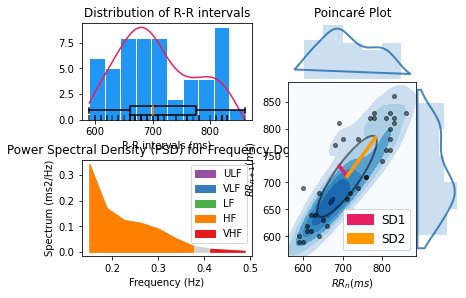

In [7]:
# Download and sort database to Sorted Directory
de = DataExtraction(f'{directory}Sorted')
de.download_data()
de.sort_data()

# For each participant, segment, clean and extract data
print("Pre-processing data...")
for index in range(1): # number_of_participants
    # show plots for first participant only
    show_plot = True if index==0 else False

    # skip if features already extracted, otherwise use extract using sorted data
    if not Utilities.check_csv_exists(f'{directory}FeaturesExtracted', index):
        df = Utilities.load_dataframe(Utilities.check_csv_exists(f'{directory}Sorted', index))
        # interpolate, segment using sliding window and clean data
        pp = PreProcessing(df, sampling_rate)
        pp.interpolate()
        pp.segment(window_length, overlap)
        pp.clean()
        sampled_ECG = pp.get_samples()

        # extract feautres for each segment
        fe = FeatureExtraction(sampled_ECG, show_plot)
        fe.neurokit_features(HRV=True, EDR=False)
        Utilities.progress_bar(index+1, number_of_participants)